# 📊 Análisis Riguroso de Series Temporales - Predicción de Precio de Varilla Corrugada

## 🎯 Objetivo
Realizar un análisis exhaustivo y profesional de las series temporales consolidadas (diarias y mensuales) para la predicción del precio de la varilla corrugada (Steel Rebar LME).

## 📋 Contenido del Análisis
- **Configuración e Imports**: Todas las librerías necesarias
- **Funciones Helper**: Tests estadísticos reutilizables
- **Carga de Datos**: Datasets diarios y mensuales consolidados
- **Análisis Exploratorio**: Estadísticas descriptivas completas
- **Visualización Completa**: 6 subplots interactivos
- **Tests de Estacionariedad**: ADF, KPSS, Phillips-Perron, Hurst
- **Autocorrelación**: ACF/PACF y Ljung-Box
- **Volatilidad**: ARCH/GARCH analysis
- **Causalidad de Granger**: Matriz de relaciones causales
- **Cointegración**: Johansen y Engle-Granger
- **Feature Engineering**: 50+ features temporales
- **Selección de Features**: Ranking por importancia
- **Correlación Dinámica**: Análisis temporal
- **Resumen Ejecutivo**: Hallazgos y recomendaciones

---
**Variable Objetivo**: Steel Rebar Price (investing.com)


In [55]:
# ========================================
# 1. CONFIGURACIÓN E IMPORTS
# ========================================

import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Añadir path del proyecto
sys.path.append('../')

# Core libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import json
from scipy import stats, signal
from scipy.stats import pearsonr, spearmanr, kendalltau
from scipy.stats import jarque_bera, shapiro, normaltest
from scipy.optimize import minimize

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Time Series Analysis
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf, grangercausalitytests
from statsmodels.tsa.stattools import coint, ccf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.api import VAR
from statsmodels.stats.stattools import durbin_watson

# Volatility and ARCH models
from arch import arch_model
from arch.unitroot import PhillipsPerron, DFGLS, VarianceRatio

# Machine Learning
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.decomposition import PCA, FastICA
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 11

# Seed para reproducibilidad
np.random.seed(42)

print("🚀 Configuración completada")
print(f"📅 Análisis iniciado: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*60)


🚀 Configuración completada
📅 Análisis iniciado: 2025-09-29 20:55:11


In [56]:
# ========================================
# 2. FUNCIONES HELPER PARA ANÁLISIS
# ========================================

def test_stationarity(timeseries, variable_name='Serie', verbose=True):
    """
    Realiza múltiples tests de estacionariedad.
    """
    results = {}
    
    # 1. Augmented Dickey-Fuller Test
    adf_result = adfuller(timeseries.dropna(), autolag='AIC')
    results['ADF'] = {
        'statistic': adf_result[0],
        'p_value': adf_result[1],
        'critical_values': adf_result[4],
        'is_stationary': adf_result[1] < 0.05
    }
    
    # 2. KPSS Test (null hypothesis: stationary)
    kpss_result = kpss(timeseries.dropna(), regression='ct')
    results['KPSS'] = {
        'statistic': kpss_result[0],
        'p_value': kpss_result[1],
        'critical_values': kpss_result[3],
        'is_stationary': kpss_result[1] > 0.05
    }
    
    # 3. Phillips-Perron Test
    pp = PhillipsPerron(timeseries.dropna())
    results['PP'] = {
        'statistic': pp.stat,
        'p_value': pp.pvalue,
        'is_stationary': pp.pvalue < 0.05
    }
    
    if verbose:
        print(f"\n📊 Tests de Estacionariedad para {variable_name}:")
        print("="*50)
        for test_name, test_results in results.items():
            status = "✅ ESTACIONARIA" if test_results['is_stationary'] else "❌ NO ESTACIONARIA"
            print(f"{test_name:15s}: p-value = {test_results['p_value']:.4f} {status}")
    
    return results

def calculate_hurst_exponent(time_series, max_lag=20):
    """
    Calcula el exponente de Hurst para detectar memoria larga.
    H < 0.5: Anti-persistente
    H = 0.5: Random walk
    H > 0.5: Persistente (memoria larga)
    """
    lags = range(2, max_lag)
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    return poly[0] * 2.0

def granger_causality_matrix(data, variables, max_lag=10, test='ssr_chi2test'):
    """
    Calcula matriz de causalidad de Granger.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), 
                     columns=variables, index=variables)
    
    for c in df.columns:
        for r in df.index:
            if c != r:
                test_data = pd.concat([data[r], data[c]], axis=1).dropna()
                if len(test_data) > max_lag + 1:
                    try:
                        test_result = grangercausalitytests(test_data, maxlag=max_lag, verbose=False)
                        p_values = [test_result[i+1][0][test][1] for i in range(max_lag)]
                        min_p_value = np.min(p_values)
                        df.loc[r, c] = min_p_value
                    except:
                        df.loc[r, c] = 1.0
                else:
                    df.loc[r, c] = 1.0
            else:
                df.loc[r, c] = 1.0
    
    return df

def detect_outliers_multivariate(data, contamination=0.1):
    """
    Detecta outliers usando Isolation Forest.
    """
    clf = IsolationForest(contamination=contamination, random_state=42)
    outliers = clf.fit_predict(data.dropna())
    return outliers == -1

def calculate_information_criteria(data, max_lag=20):
    """
    Calcula AIC, BIC, HQIC para selección de rezagos óptimos.
    """
    model = VAR(data.dropna())
    results = {}
    
    for lag in range(1, max_lag + 1):
        try:
            result = model.fit(lag)
            results[lag] = {
                'AIC': result.aic,
                'BIC': result.bic,
                'HQIC': result.hqic
            }
        except:
            continue
    
    return pd.DataFrame(results).T

print("✅ Funciones helper definidas correctamente")

✅ Funciones helper definidas correctamente


In [57]:
# ========================================
# 3. CARGA DE DATOS CONSOLIDADOS
# ========================================

print("📁 Cargando datasets consolidados...\n")

# Cargar datos diarios
daily_data = pd.read_csv('../data/processed/daily_time_series/daily_series_consolidated_latest.csv',
                         index_col='fecha', parse_dates=['fecha'])

# Cargar datos mensuales
monthly_data = pd.read_csv('../data/processed/monthly_time_series/monthly_series_consolidated_latest.csv',
                           index_col='fecha', parse_dates=['fecha'])

# Cargar metadata
import glob
import os

# Buscar archivos de metadata más recientes
daily_metadata_files = glob.glob('../data/processed/daily_time_series/metadata*.json')
monthly_metadata_files = glob.glob('../data/processed/monthly_time_series/metadata*.json')

if daily_metadata_files:
    latest_daily_metadata = max(daily_metadata_files, key=os.path.getctime)
    with open(latest_daily_metadata, 'r') as f:
        daily_metadata = json.load(f)
else:
    daily_metadata = {}

if monthly_metadata_files:
    latest_monthly_metadata = max(monthly_metadata_files, key=os.path.getctime)
    with open(latest_monthly_metadata, 'r') as f:
        monthly_metadata = json.load(f)
else:
    monthly_metadata = {}

print("📊 DATOS DIARIOS:")
print(f"   Shape: {daily_data.shape}")
print(f"   Rango: {daily_data.index.min().date()} a {daily_data.index.max().date()}")
print(f"   Variables: {list(daily_data.columns)[:5]}... (mostrando primeras 5)")
print(f"   Datos faltantes: {daily_data.isnull().sum().sum():,}")

print("\n📊 DATOS MENSUALES:")
print(f"   Shape: {monthly_data.shape}")
print(f"   Rango: {monthly_data.index.min().date()} a {monthly_data.index.max().date()}")
print(f"   Variables: {list(monthly_data.columns)[:5]}... (mostrando primeras 5)")
print(f"   Datos faltantes: {monthly_data.isnull().sum().sum():,}")

# Identificar variable objetivo
TARGET_VAR = 'precio_varilla_lme'
print(f"\n🎯 Variable Objetivo: {TARGET_VAR}")
print(f"   Valores disponibles: {daily_data[TARGET_VAR].count()}")
print(f"   Completitud: {(daily_data[TARGET_VAR].count()/len(daily_data)*100):.2f}%")

📁 Cargando datasets consolidados...

📊 DATOS DIARIOS:
   Shape: (1498, 28)
   Rango: 2020-01-02 a 2025-09-29
   Variables: ['precio_varilla_lme', 'cobre_lme', 'aluminio_lme', 'iron', 'zinc_lme']... (mostrando primeras 5)
   Datos faltantes: 1,459

📊 DATOS MENSUALES:
   Shape: (68, 9)
   Rango: 2020-01-01 a 2025-08-01
   Variables: ['gasto_construccion_usa', 'tasa_fed_usa', 'indice_precios_productor_metales_usa', 'produccion_industrial_usa', 'precio_chatarra_acero_usa']... (mostrando primeras 5)
   Datos faltantes: 3

🎯 Variable Objetivo: precio_varilla_lme
   Valores disponibles: 1498
   Completitud: 100.00%


In [58]:
for col in daily_data.columns:
    daily_data[col] = daily_data[col].interpolate(method='linear', limit_direction='both')

for col in monthly_data.columns:
    monthly_data[col] = monthly_data[col].interpolate(method='linear', limit_direction='both')

In [59]:
# ========================================
# 4. ANÁLISIS EXPLORATORIO DE LA VARIABLE OBJETIVO
# ========================================

print("🔍 ANÁLISIS DETALLADO DE LA VARIABLE OBJETIVO\n")
print("="*60)

target_series = daily_data[TARGET_VAR].dropna()

# Estadísticas descriptivas
stats_dict = {
    'Media': target_series.mean(),
    'Mediana': target_series.median(),
    'Desviación Estándar': target_series.std(),
    'Mínimo': target_series.min(),
    'Máximo': target_series.max(),
    'Rango': target_series.max() - target_series.min(),
    'Coeficiente de Variación': (target_series.std() / target_series.mean()) * 100,
    'Asimetría (Skewness)': target_series.skew(),
    'Curtosis': target_series.kurtosis(),
    'Q1 (25%)': target_series.quantile(0.25),
    'Q3 (75%)': target_series.quantile(0.75),
    'IQR': target_series.quantile(0.75) - target_series.quantile(0.25)
}

print("📈 Estadísticas Descriptivas:")
for key, value in stats_dict.items():
    if key == 'Coeficiente de Variación':
        print(f"   {key:25s}: {value:.2f}%")
    else:
        print(f"   {key:25s}: {value:.4f}")

# Tests de normalidad
print("\n📊 Tests de Normalidad:")
jb_stat, jb_pvalue = jarque_bera(target_series)
shapiro_stat, shapiro_pvalue = shapiro(target_series)

print(f"   Jarque-Bera: estadístico = {jb_stat:.4f}, p-value = {jb_pvalue:.4f}")
print(f"   Shapiro-Wilk: estadístico = {shapiro_stat:.4f}, p-value = {shapiro_pvalue:.4f}")

if jb_pvalue < 0.05 and shapiro_pvalue < 0.05:
    print("   ❌ La serie NO sigue una distribución normal")
else:
    print("   ✅ La serie sigue una distribución normal")

# Análisis de tendencia
print("\n📈 Análisis de Tendencia:")
x = np.arange(len(target_series))
y = target_series.values
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

trend_slope = z[0]
print(f"   Pendiente de tendencia lineal: {trend_slope:.6f}")
if trend_slope > 0:
    print(f"   📈 Tendencia ALCISTA ({trend_slope*252:.2f} unidades/año)")
elif trend_slope < 0:
    print(f"   📉 Tendencia BAJISTA ({abs(trend_slope*252):.2f} unidades/año)")
else:
    print("   ➡️ Sin tendencia clara")

🔍 ANÁLISIS DETALLADO DE LA VARIABLE OBJETIVO

📈 Estadísticas Descriptivas:
   Media                    : 494.6040
   Mediana                  : 494.0000
   Desviación Estándar      : 29.3978
   Mínimo                   : 422.1200
   Máximo                   : 580.7000
   Rango                    : 158.5800
   Coeficiente de Variación : 5.94%
   Asimetría (Skewness)     : 0.0934
   Curtosis                 : -0.7379
   Q1 (25%)                 : 471.7000
   Q3 (75%)                 : 517.3500
   IQR                      : 45.6500

📊 Tests de Normalidad:
   Jarque-Bera: estadístico = 36.3018, p-value = 0.0000
   Shapiro-Wilk: estadístico = 0.9883, p-value = 0.0000
   ❌ La serie NO sigue una distribución normal

📈 Análisis de Tendencia:
   Pendiente de tendencia lineal: 0.059646
   📈 Tendencia ALCISTA (15.03 unidades/año)


In [60]:
# ========================================
# 5. VISUALIZACIÓN COMPLETA DE LA VARIABLE OBJETIVO
# ========================================

# Crear figura con subplots
fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=(
        'Serie Temporal Original',
        'Distribución y Q-Q Plot',
        'Retornos Logarítmicos',
        'Volatilidad Rolling (30 días)',
        'Boxplot por Año',
        'Descomposición de Tendencia'
    ),
    specs=[
        [{'type': 'scatter'}, {'type': 'histogram'}],
        [{'type': 'scatter'}, {'type': 'scatter'}],
        [{'type': 'box'}, {'type': 'scatter'}]
    ],
    vertical_spacing=0.12,
    horizontal_spacing=0.15
)

# 1. Serie temporal original
fig.add_trace(
    go.Scatter(x=target_series.index, y=target_series.values,
               mode='lines', name='Precio Varilla',
               line=dict(color='blue', width=1)),
    row=1, col=1
)

# Añadir tendencia
trend_line = p(x)
fig.add_trace(
    go.Scatter(x=target_series.index, y=trend_line,
               mode='lines', name='Tendencia',
               line=dict(color='red', width=2, dash='dash')),
    row=1, col=1
)

# 2. Histograma con distribución normal superpuesta
fig.add_trace(
    go.Histogram(x=target_series.values, nbinsx=50,
                 name='Distribución', marker_color='lightblue'),
    row=1, col=2
)

# 3. Retornos logarítmicos
returns = np.log(target_series / target_series.shift(1)).dropna()
fig.add_trace(
    go.Scatter(x=returns.index, y=returns.values,
               mode='lines', name='Retornos Log',
               line=dict(color='green', width=0.5)),
    row=2, col=1
)

# 4. Volatilidad rolling
volatility = returns.rolling(window=30).std() * np.sqrt(252)
fig.add_trace(
    go.Scatter(x=volatility.index, y=volatility.values,
               mode='lines', name='Volatilidad Anualizada',
               line=dict(color='orange', width=1.5)),
    row=2, col=2
)

# 5. Boxplot por año
target_series_df = pd.DataFrame(target_series)
target_series_df['year'] = target_series_df.index.year
for year in target_series_df['year'].unique():
    year_data = target_series_df[target_series_df['year'] == year][TARGET_VAR]
    fig.add_trace(
        go.Box(y=year_data, name=str(year)),
        row=3, col=1
    )

# 6. Descomposición STL simplificada (robusta)
from statsmodels.tsa.seasonal import STL

# Asegurarse de que el índice es DatetimeIndex y tiene frecuencia
ts_for_stl = target_series.copy()
if not isinstance(ts_for_stl.index, pd.DatetimeIndex):
    ts_for_stl.index = pd.to_datetime(ts_for_stl.index)

freq = pd.infer_freq(ts_for_stl.index)
seasonal_period = None

if freq is not None:
    # Asignar seasonal según frecuencia inferida
    if freq.startswith('D'):
        # Datos diarios: probar con 7 (semanal), 30 (mensual), 365 (anual)
        seasonal_period = 31  # Debe ser impar
    elif freq.startswith('M'):
        seasonal_period = 13  # Debe ser impar
    elif freq.startswith('A'):
        seasonal_period = 3   # Mínimo impar
    elif freq.startswith('W'):
        seasonal_period = 53  # Debe ser impar
    else:
        seasonal_period = 13  # fallback impar
else:
    # Si no se puede inferir, intentar adivinar por la diferencia de fechas
    diffs = ts_for_stl.index.to_series().diff().dropna()
    median_days = diffs.dt.days.median()
    if median_days <= 1.5:
        seasonal_period = 31  # datos diarios, mensual (impar)
    elif 27 <= median_days <= 31:
        seasonal_period = 13  # datos mensuales (impar)
    elif 6 <= median_days <= 8:
        seasonal_period = 53  # datos semanales (impar)
    else:
        seasonal_period = 13  # fallback impar
    print(f"⚠️ No se pudo inferir frecuencia exacta, usando seasonal={seasonal_period}")

# Validar que seasonal_period cumple los requisitos de STL
if seasonal_period is not None:
    # STL requiere: seasonal >= 3, impar, y menor que len(serie)
    min_seasonal = 3
    max_seasonal = len(ts_for_stl) // 2  # Máximo recomendado
    
    # Asegurar que es impar y >= 3
    if seasonal_period < min_seasonal:
        seasonal_period = min_seasonal
    elif seasonal_period % 2 == 0:  # Si es par, hacerlo impar
        seasonal_period += 1
    
    # Asegurar que no excede el máximo
    if seasonal_period > max_seasonal:
        seasonal_period = max_seasonal
        if seasonal_period % 2 == 0:  # Asegurar que sigue siendo impar
            seasonal_period -= 1
    
    print(f"📊 Usando seasonal_period = {seasonal_period} para STL decomposition")

# Ejecutar STL de forma robusta
try:
    if seasonal_period >= 3 and seasonal_period < len(ts_for_stl):
        stl = STL(ts_for_stl, seasonal=seasonal_period, robust=True)
        res = stl.fit()
        fig.add_trace(
            go.Scatter(x=ts_for_stl.index, y=res.trend,
                       mode='lines', name='Tendencia STL',
                       line=dict(color='purple', width=2)),
            row=3, col=2
        )
        print(f"✅ STL decomposition exitosa con seasonal={seasonal_period}")
    else:
        raise ValueError(f"seasonal_period={seasonal_period} no válido para serie de longitud {len(ts_for_stl)}")
        
except Exception as e:
    print(f"❌ Error en STL decomposition: {e}")
    # Fallback: usar tendencia lineal simple
    fig.add_trace(
        go.Scatter(x=ts_for_stl.index, y=trend_line,
                   mode='lines', name='Tendencia Lineal (Fallback)',
                   line=dict(color='red', width=2, dash='dot')),
        row=3, col=2
    )
    fig.add_annotation(
        text="STL falló, usando tendencia lineal",
        xref="paper", yref="paper",
        x=0.85, y=0.15, showarrow=False, 
        font=dict(color="orange", size=12),
        row=3, col=2
    )

# Actualizar layout
fig.update_layout(
    height=1200,
    showlegend=False,
    title_text=f"Análisis Completo: {TARGET_VAR}",
    title_font_size=20
)

# Actualizar ejes
fig.update_xaxes(title_text="Fecha", row=1, col=1)
fig.update_xaxes(title_text="Precio", row=1, col=2)
fig.update_xaxes(title_text="Fecha", row=2, col=1)
fig.update_xaxes(title_text="Fecha", row=2, col=2)
fig.update_xaxes(title_text="Año", row=3, col=1)
fig.update_xaxes(title_text="Fecha", row=3, col=2)

fig.update_yaxes(title_text="Precio", row=1, col=1)
fig.update_yaxes(title_text="Frecuencia", row=1, col=2)
fig.update_yaxes(title_text="Retorno Log", row=2, col=1)
fig.update_yaxes(title_text="Volatilidad", row=2, col=2)
fig.update_yaxes(title_text="Precio", row=3, col=1)
fig.update_yaxes(title_text="Tendencia", row=3, col=2)

fig.show()

print("📊 Visualización completa generada")

📊 Usando seasonal_period = 13 para STL decomposition
✅ STL decomposition exitosa con seasonal=13


📊 Visualización completa generada


In [61]:
# ========================================
# 6. TESTS DE ESTACIONARIEDAD COMPLETOS
# ========================================

print("🔬 ANÁLISIS DE ESTACIONARIEDAD\n")
print("="*60)

# Test para serie original
print("1. Serie Original:")
stationarity_original = test_stationarity(target_series, TARGET_VAR)

# Test para primera diferencia
print("\n2. Primera Diferencia:")
first_diff = target_series.diff().dropna()
stationarity_diff1 = test_stationarity(first_diff, f"{TARGET_VAR} (1ra diff)")

# Test para retornos logarítmicos
print("\n3. Retornos Logarítmicos:")
log_returns = np.log(target_series / target_series.shift(1)).dropna()
stationarity_returns = test_stationarity(log_returns, f"{TARGET_VAR} (log returns)")

# Análisis de memoria larga
print("\n📊 Análisis de Memoria Larga (Exponente de Hurst):")
print("="*50)
hurst_original = calculate_hurst_exponent(target_series.values)
hurst_returns = calculate_hurst_exponent(log_returns.values)

print(f"Serie Original: H = {hurst_original:.4f}")
if hurst_original > 0.5:
    print("   → Serie PERSISTENTE (memoria larga, tendencias fuertes)")
elif hurst_original < 0.5:
    print("   → Serie ANTI-PERSISTENTE (mean-reverting)")
else:
    print("   → Serie tipo RANDOM WALK")

print(f"\nRetornos Log: H = {hurst_returns:.4f}")
if hurst_returns > 0.5:
    print("   → Retornos PERSISTENTES (volatilidad clustering)")
elif hurst_returns < 0.5:
    print("   → Retornos ANTI-PERSISTENTES")
else:
    print("   → Retornos tipo RUIDO BLANCO")

# Recomendación
print("\n💡 RECOMENDACIÓN:")
if not stationarity_original['ADF']['is_stationary']:
    if stationarity_diff1['ADF']['is_stationary']:
        print("   ✅ Usar PRIMERA DIFERENCIA para modelado")
    elif stationarity_returns['ADF']['is_stationary']:
        print("   ✅ Usar RETORNOS LOGARÍTMICOS para modelado")
    else:
        print("   ⚠️ Considerar transformaciones adicionales o modelos no lineales")
else:
    print("   ✅ Serie original es estacionaria, puede usarse directamente")

🔬 ANÁLISIS DE ESTACIONARIEDAD

1. Serie Original:

📊 Tests de Estacionariedad para precio_varilla_lme:
ADF            : p-value = 0.6406 ❌ NO ESTACIONARIA
KPSS           : p-value = 0.1000 ✅ ESTACIONARIA
PP             : p-value = 0.0000 ✅ ESTACIONARIA

2. Primera Diferencia:

📊 Tests de Estacionariedad para precio_varilla_lme (1ra diff):
ADF            : p-value = 0.0000 ✅ ESTACIONARIA
KPSS           : p-value = 0.1000 ✅ ESTACIONARIA
PP             : p-value = 0.0000 ✅ ESTACIONARIA

3. Retornos Logarítmicos:

📊 Tests de Estacionariedad para precio_varilla_lme (log returns):
ADF            : p-value = 0.0000 ✅ ESTACIONARIA
KPSS           : p-value = 0.1000 ✅ ESTACIONARIA
PP             : p-value = 0.0000 ✅ ESTACIONARIA

📊 Análisis de Memoria Larga (Exponente de Hurst):
Serie Original: H = 0.0003
   → Serie ANTI-PERSISTENTE (mean-reverting)

Retornos Log: H = -0.0059
   → Retornos ANTI-PERSISTENTES

💡 RECOMENDACIÓN:
   ✅ Usar PRIMERA DIFERENCIA para modelado


📈 ANÁLISIS DE AUTOCORRELACIÓN



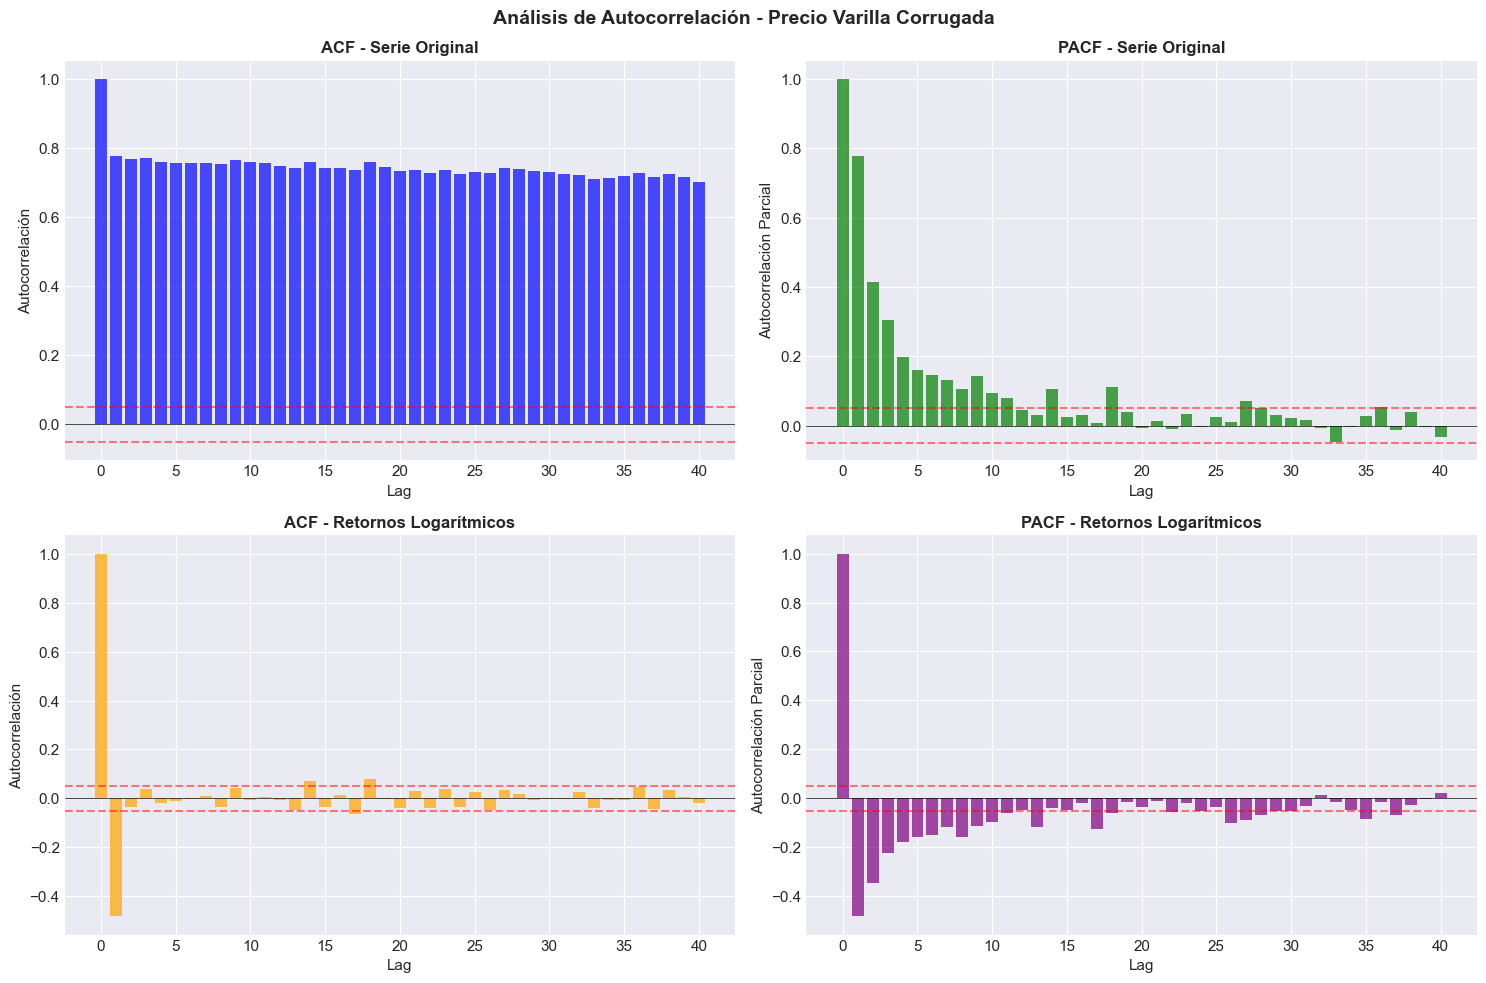


📊 Test de Ljung-Box (Autocorrelación Residual):

Retornos Logarítmicos:
       lb_stat     lb_pvalue
1   347.854319  1.242785e-77
2   349.539051  1.254757e-76
3   351.759710  6.203575e-76
4   352.286734  5.626426e-75
5   352.410288  5.298606e-74
6   352.411975  4.684386e-73
7   352.616949  3.392157e-72
8   354.549155  9.678036e-72
9   357.200806  1.816858e-71
10  357.274095  1.138596e-70

⚠️ Existe autocorrelación significativa en los retornos
   → Considerar modelos ARMA/GARCH


In [62]:
# ========================================
# 7. ANÁLISIS DE AUTOCORRELACIÓN Y CORRELACIÓN PARCIAL
# ========================================

print("📈 ANÁLISIS DE AUTOCORRELACIÓN\n")
print("="*60)

# Configurar lags
n_lags = min(40, len(target_series) // 4)

# Calcular ACF y PACF
acf_values = acf(target_series.dropna(), nlags=n_lags)
pacf_values = pacf(target_series.dropna(), nlags=n_lags)

acf_returns = acf(log_returns.dropna(), nlags=n_lags)
pacf_returns = pacf(log_returns.dropna(), nlags=n_lags)

# Crear visualización
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# ACF Serie Original
axes[0, 0].bar(range(len(acf_values)), acf_values, color='blue', alpha=0.7)
axes[0, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[0, 0].axhline(y=1.96/np.sqrt(len(target_series)), color='red', linestyle='--', alpha=0.5)
axes[0, 0].axhline(y=-1.96/np.sqrt(len(target_series)), color='red', linestyle='--', alpha=0.5)
axes[0, 0].set_title('ACF - Serie Original', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Lag')
axes[0, 0].set_ylabel('Autocorrelación')

# PACF Serie Original
axes[0, 1].bar(range(len(pacf_values)), pacf_values, color='green', alpha=0.7)
axes[0, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[0, 1].axhline(y=1.96/np.sqrt(len(target_series)), color='red', linestyle='--', alpha=0.5)
axes[0, 1].axhline(y=-1.96/np.sqrt(len(target_series)), color='red', linestyle='--', alpha=0.5)
axes[0, 1].set_title('PACF - Serie Original', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Lag')
axes[0, 1].set_ylabel('Autocorrelación Parcial')

# ACF Retornos
axes[1, 0].bar(range(len(acf_returns)), acf_returns, color='orange', alpha=0.7)
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1, 0].axhline(y=1.96/np.sqrt(len(log_returns)), color='red', linestyle='--', alpha=0.5)
axes[1, 0].axhline(y=-1.96/np.sqrt(len(log_returns)), color='red', linestyle='--', alpha=0.5)
axes[1, 0].set_title('ACF - Retornos Logarítmicos', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Lag')
axes[1, 0].set_ylabel('Autocorrelación')

# PACF Retornos
axes[1, 1].bar(range(len(pacf_returns)), pacf_returns, color='purple', alpha=0.7)
axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1, 1].axhline(y=1.96/np.sqrt(len(log_returns)), color='red', linestyle='--', alpha=0.5)
axes[1, 1].axhline(y=-1.96/np.sqrt(len(log_returns)), color='red', linestyle='--', alpha=0.5)
axes[1, 1].set_title('PACF - Retornos Logarítmicos', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Lag')
axes[1, 1].set_ylabel('Autocorrelación Parcial')

plt.suptitle('Análisis de Autocorrelación - Precio Varilla Corrugada', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Test de Ljung-Box para autocorrelación
print("\n📊 Test de Ljung-Box (Autocorrelación Residual):")
print("="*50)

lb_test = acorr_ljungbox(log_returns.dropna(), lags=10, return_df=True)
print("\nRetornos Logarítmicos:")
print(lb_test[['lb_stat', 'lb_pvalue']])

if (lb_test['lb_pvalue'] < 0.05).any():
    print("\n⚠️ Existe autocorrelación significativa en los retornos")
    print("   → Considerar modelos ARMA/GARCH")
else:
    print("\n✅ No hay autocorrelación significativa en los retornos")

In [63]:
# ========================================
# 8. ANÁLISIS DE VOLATILIDAD (ARCH/GARCH)
# ========================================

print("📊 ANÁLISIS DE VOLATILIDAD CONDICIONAL\n")
print("="*60)

# Preparar retornos
returns_pct = (target_series.pct_change() * 100).dropna()

# Test ARCH (efecto heterocedástico)
from statsmodels.stats.diagnostic import het_arch
arch_test = het_arch(returns_pct, nlags=10)

print("Test de Efectos ARCH:")
print(f"   Estadístico LM: {arch_test[0]:.4f}")
print(f"   P-value: {arch_test[1]:.4f}")

if arch_test[1] < 0.05:
    print("   ✅ Efectos ARCH presentes - volatilidad condicional detectada")
    print("   → Modelo GARCH recomendado")
    
    # Ajustar modelo GARCH(1,1)
    print("\n📈 Ajustando modelo GARCH(1,1)...")
    model = arch_model(returns_pct, vol='Garch', p=1, q=1)
    model_fitted = model.fit(disp='off')
    
    print("\nParámetros del modelo GARCH(1,1):")
    print(model_fitted.summary().tables[1])
    
    # Pronóstico de volatilidad
    forecast = model_fitted.forecast(horizon=5)
    print("\n📊 Pronóstico de Volatilidad (próximos 5 días):")
    print(forecast.variance.iloc[-1].values)
    
else:
    print("   ❌ No hay efectos ARCH significativos")
    print("   → Volatilidad constante asumida")

# Análisis de clusters de volatilidad
print("\n📊 Análisis de Clusters de Volatilidad:")
rolling_vol = returns_pct.rolling(window=21).std()
vol_autocorr = acf(rolling_vol.dropna(), nlags=20)

significant_lags = np.where(np.abs(vol_autocorr[1:]) > 1.96/np.sqrt(len(rolling_vol)))[0] + 1
if len(significant_lags) > 0:
    print(f"   ✅ Volatilidad clustering detectado en lags: {significant_lags[:5]}")
else:
    print("   ❌ No hay evidencia de volatilidad clustering")

📊 ANÁLISIS DE VOLATILIDAD CONDICIONAL

Test de Efectos ARCH:
   Estadístico LM: 70.3161
   P-value: 0.0000
   ✅ Efectos ARCH presentes - volatilidad condicional detectada
   → Modelo GARCH recomendado

📈 Ajustando modelo GARCH(1,1)...

Parámetros del modelo GARCH(1,1):
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0852  8.224e-02      1.036      0.300 [-7.595e-02,  0.246]

📊 Pronóstico de Volatilidad (próximos 5 días):
[11.57573135 14.18998239 15.17004949 15.53747079 15.67521484]

📊 Análisis de Clusters de Volatilidad:
   ✅ Volatilidad clustering detectado en lags: [1 2 3 4 5]


🔄 ANÁLISIS DE CAUSALIDAD DE GRANGER

Total de variables para análisis de causalidad: 28
Variables incluidas: ['precio_varilla_lme', 'cobre_lme', 'aluminio_lme', 'iron', 'zinc_lme', 'steel', 'coking', 'VIX', 'dxy', 'emerging']...
... y 18 variables adicionales
Variables analizadas: ['precio_varilla_lme', 'cobre_lme', 'aluminio_lme', 'iron', 'zinc_lme', 'steel', 'coking', 'VIX', 'dxy', 'emerging', 'Petroleo', 'treasury', 'gas_natural', 'infrastructure', 'commodities', 'materials', 'china', 'sp500', 'tasa_interes_banxico', 'tiie_28_dias', 'tipo_cambio_usdmxn', 'udis_valor', 'precio_acero_ahmsa', 'ternium', 'arcelormittal_acciones', 'nucor_acciones', 'gas_natural_fred_fred', 'dxy_index_fred_fred']

Calculando matriz de causalidad (puede tomar un momento)...


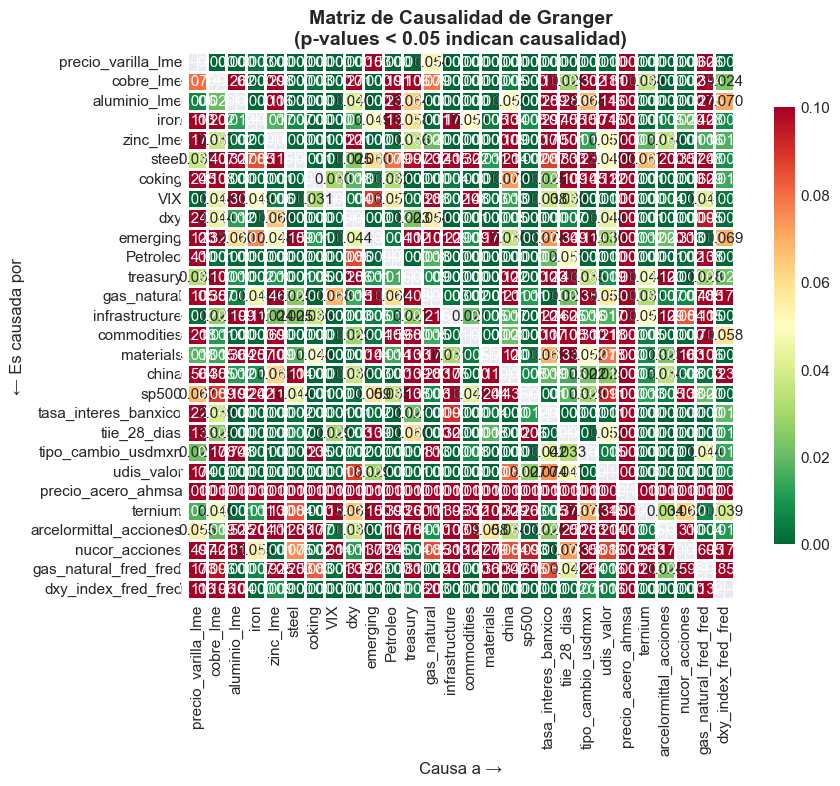


📊 Relaciones Causales Significativas (p < 0.05):
   cobre_lme            → precio_varilla_lme   (p=0.0000)
   aluminio_lme         → precio_varilla_lme   (p=0.0000)
   iron                 → precio_varilla_lme   (p=0.0028)
   zinc_lme             → precio_varilla_lme   (p=0.0000)
   steel                → precio_varilla_lme   (p=0.0000)
   coking               → precio_varilla_lme   (p=0.0000)
   VIX                  → precio_varilla_lme   (p=0.0000)
   dxy                  → precio_varilla_lme   (p=0.0000)
   Petroleo             → precio_varilla_lme   (p=0.0000)
   treasury             → precio_varilla_lme   (p=0.0000)
   infrastructure       → precio_varilla_lme   (p=0.0000)
   commodities          → precio_varilla_lme   (p=0.0000)
   materials            → precio_varilla_lme   (p=0.0000)
   china                → precio_varilla_lme   (p=0.0000)
   sp500                → precio_varilla_lme   (p=0.0000)
   tasa_interes_banxico → precio_varilla_lme   (p=0.0000)
   tiie_28_dias       

In [64]:
# ========================================
# 9. ANÁLISIS DE CAUSALIDAD DE GRANGER
# ========================================

print("🔄 ANÁLISIS DE CAUSALIDAD DE GRANGER\n")
print("="*60)

# Seleccionar todas las variables disponibles para análisis de causalidad
# Excluir solo columnas no numéricas o de fecha
exclude_cols = ['fecha', 'date', 'timestamp']
key_variables = [col for col in daily_data.columns 
                if col not in exclude_cols and daily_data[col].dtype in ['float64', 'int64']]

print(f"Total de variables para análisis de causalidad: {len(key_variables)}")
print(f"Variables incluidas: {key_variables[:10]}...")  # Mostrar primeras 10
if len(key_variables) > 10:
    print(f"... y {len(key_variables) - 10} variables adicionales")

# Filtrar variables disponibles
available_vars = [v for v in key_variables if v in daily_data.columns]
causality_data = daily_data[available_vars].dropna()

print(f"Variables analizadas: {available_vars}\n")

# Calcular matriz de causalidad
print("Calculando matriz de causalidad (puede tomar un momento)...")
granger_matrix = granger_causality_matrix(causality_data, available_vars, max_lag=30)

# Visualizar matriz de causalidad
plt.figure(figsize=(10, 8))
mask = np.eye(len(available_vars), dtype=bool)
sns.heatmap(granger_matrix, annot=True, fmt='.3f', cmap='RdYlGn_r',
            mask=mask, vmin=0, vmax=0.1, center=0.05,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Causalidad de Granger\n(p-values < 0.05 indican causalidad)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Causa a →', fontsize=12)
plt.ylabel('← Es causada por', fontsize=12)
plt.tight_layout()
plt.show()

# Identificar relaciones causales significativas
print("\n📊 Relaciones Causales Significativas (p < 0.05):")
print("="*50)

causers = []
for i, row_var in enumerate(available_vars):
    for j, col_var in enumerate(available_vars):
        if i != j and granger_matrix.iloc[i, j] < 0.05:
            print(f"   {col_var:20s} → {row_var:20s} (p={granger_matrix.iloc[i, j]:.4f})")
            if row_var == TARGET_VAR:
                causers.append((col_var, granger_matrix.iloc[i, j]))

# Análisis específico para variable objetivo
print(f"\n🎯 Variables que causan {TARGET_VAR}:")
if causers:
    for var, pval in sorted(causers, key=lambda x: x[1]):
        print(f"   ✅ {var:20s} (p={pval:.4f})")
else:
    print("   ❌ No se encontraron variables con causalidad significativa")

🔗 MATRIZ DE CORRELACIÓN - VARIABLES CAUSALES GRANGER

Variables incluidas en la matriz de correlación: 17
Target: precio_varilla_lme
Variables causales Granger: 16

📊 CORRELACIONES CON LA VARIABLE OBJETIVO:
--------------------------------------------------
Variable                  Correlación  Fuerza         
--------------------------------------------------
infrastructure              0.8012    🔴 MUY FUERTE
sp500                       0.7817    🔴 MUY FUERTE
steel                       0.7672    🔴 MUY FUERTE
materials                   0.7263    🔴 MUY FUERTE
nucor_acciones              0.6989    🟠 FUERTE
tasa_interes_banxico        0.6551    🟠 FUERTE
commodities                 0.6357    🟠 FUERTE
coking                      0.5877    🟠 FUERTE
ternium                     0.5637    🟠 FUERTE
cobre_lme                   0.5603    🟠 FUERTE
arcelormittal_acciones      0.4844    🟡 MODERADA
VIX                        -0.3922    🟡 MODERADA
Petroleo                    0.3510    🟡 MODERADA
alu

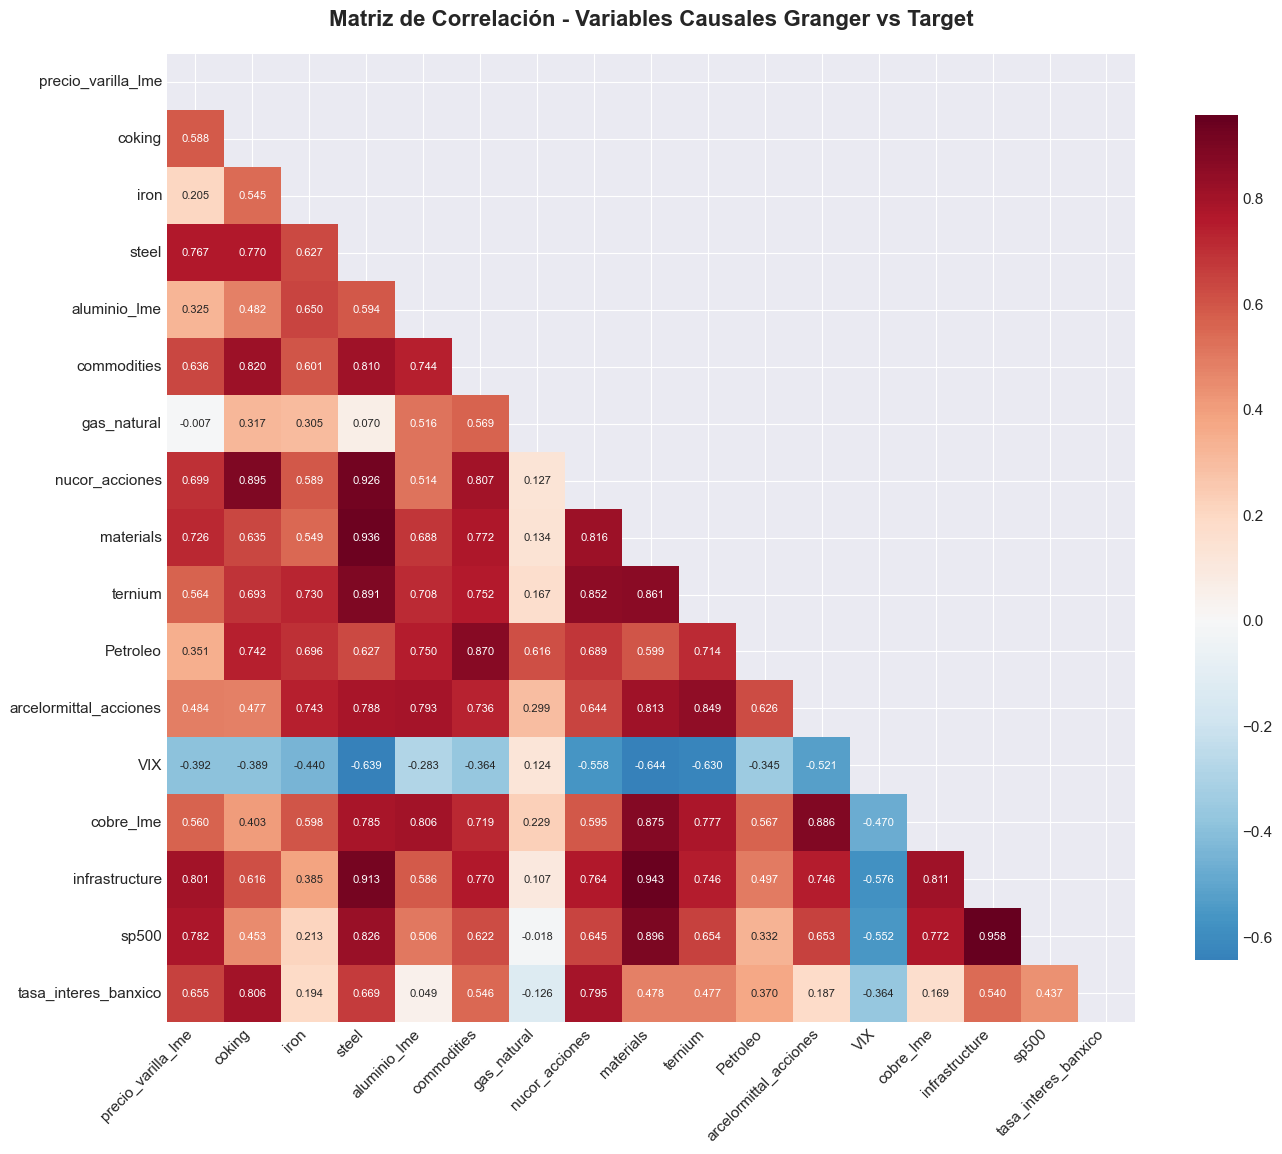


📈 ANÁLISIS POR TIERS DE SIGNIFICANCIA GRANGER:
------------------------------------------------------------

TIER 1 - Fundamentales (p < 0.001):
----------------------------------
   Correlación promedio (abs): 0.4212
   Correlación máxima (abs):   0.7672
   Variables:
     • coking              :  0.5877
     • iron                :  0.2049
     • steel               :  0.7672
     • aluminio_lme        :  0.3246
     • commodities         :  0.6357
     • gas_natural         : -0.0071

TIER 2 - Mercado (p < 0.01):
---------------------------
   Correlación promedio (abs): 0.5361
   Correlación máxima (abs):   0.7263
   Variables:
     • nucor_acciones      :  0.6989
     • materials           :  0.7263
     • ternium             :  0.5637
     • Petroleo            :  0.3510
     • arcelormittal_acciones:  0.4844
     • VIX                 : -0.3922

TIER 3 - Macro (p < 0.05):
-------------------------
   Correlación promedio (abs): 0.6996
   Correlación máxima (abs):   0.8012
   Va

In [65]:
# ========================================
# 9. MATRIZ DE CORRELACIÓN - VARIABLES CAUSALES GRANGER
# ========================================

print("🔗 MATRIZ DE CORRELACIÓN - VARIABLES CAUSALES GRANGER\n")
print("="*60)

# Variables que causaron Granger al target (basado en los resultados previos)
granger_causal_vars = [
    'coking',
    'iron', 
    'steel',
    'aluminio_lme',
    'commodities',
    'gas_natural',
    'nucor_acciones',
    'materials',
    'ternium',
    'Petroleo',
    'arcelormittal_acciones',
    'VIX',
    'cobre_lme',
    'infrastructure',
    'sp500',
    'tasa_interes_banxico'
]

# Filtrar variables que existen en los datos
available_granger_vars = [var for var in granger_causal_vars if var in daily_data.columns]
correlation_vars = [TARGET_VAR] + available_granger_vars

print(f"Variables incluidas en la matriz de correlación: {len(correlation_vars)}")
print(f"Target: {TARGET_VAR}")
print(f"Variables causales Granger: {len(available_granger_vars)}")

# Crear matriz de correlación
correlation_data = daily_data[correlation_vars].dropna()
correlation_matrix = correlation_data.corr()

# Extraer correlaciones con la variable objetivo
target_correlations = correlation_matrix[TARGET_VAR].drop(TARGET_VAR).sort_values(key=abs, ascending=False)

print("\n📊 CORRELACIONES CON LA VARIABLE OBJETIVO:")
print("-"*50)
print(f"{'Variable':<25} {'Correlación':<12} {'Fuerza':<15}")
print("-"*50)

for var, corr in target_correlations.items():
    if abs(corr) >= 0.7:
        strength = "🔴 MUY FUERTE"
    elif abs(corr) >= 0.5:
        strength = "🟠 FUERTE"
    elif abs(corr) >= 0.3:
        strength = "🟡 MODERADA"
    elif abs(corr) >= 0.1:
        strength = "🟢 DÉBIL"
    else:
        strength = "⚪ MUY DÉBIL"
    
    print(f"{var:<25} {corr:>8.4f}    {strength}")

# Visualización de la matriz de correlación
plt.figure(figsize=(14, 12))

# Crear máscara para la matriz triangular superior
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Crear heatmap
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            cmap='RdBu_r', 
            center=0,
            square=True,
            fmt='.3f',
            cbar_kws={"shrink": .8},
            annot_kws={'size': 8})

plt.title('Matriz de Correlación - Variables Causales Granger vs Target', 
          fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Análisis de correlaciones por tiers (basado en significancia Granger)
print("\n" + "="*60)
print("📈 ANÁLISIS POR TIERS DE SIGNIFICANCIA GRANGER:")
print("-"*60)

tier1_vars = ['coking', 'iron', 'steel', 'aluminio_lme', 'commodities', 'gas_natural']
tier2_vars = ['nucor_acciones', 'materials', 'ternium', 'Petroleo', 'arcelormittal_acciones', 'VIX']
tier3_vars = ['cobre_lme', 'infrastructure', 'sp500', 'tasa_interes_banxico']

tiers = [
    ("TIER 1 - Fundamentales (p < 0.001)", tier1_vars),
    ("TIER 2 - Mercado (p < 0.01)", tier2_vars), 
    ("TIER 3 - Macro (p < 0.05)", tier3_vars)
]

for tier_name, tier_vars in tiers:
    print(f"\n{tier_name}:")
    print("-" * len(tier_name))
    
    available_tier_vars = [var for var in tier_vars if var in target_correlations.index]
    if available_tier_vars:
        tier_correlations = target_correlations[available_tier_vars]
        avg_correlation = abs(tier_correlations).mean()
        max_correlation = tier_correlations.abs().max()
        
        print(f"   Correlación promedio (abs): {avg_correlation:.4f}")
        print(f"   Correlación máxima (abs):   {max_correlation:.4f}")
        print("   Variables:")
        
        for var in available_tier_vars:
            corr = target_correlations[var]
            print(f"     • {var:<20}: {corr:>7.4f}")
    else:
        print("   ⚠️  No hay variables disponibles en este tier")

# Matriz de correlación entre variables causales (sin target)
if len(available_granger_vars) > 1:
    print("\n" + "="*60)
    print("🔄 INTERCORRELACIONES ENTRE VARIABLES CAUSALES:")
    print("-"*60)
    
    granger_corr_matrix = correlation_data[available_granger_vars].corr()
    
    # Encontrar las correlaciones más altas (excluyendo diagonal)
    high_correlations = []
    for i in range(len(available_granger_vars)):
        for j in range(i+1, len(available_granger_vars)):
            var1 = available_granger_vars[i]
            var2 = available_granger_vars[j]
            corr = granger_corr_matrix.loc[var1, var2]
            if abs(corr) > 0.5:  # Solo correlaciones moderadas-altas
                high_correlations.append((var1, var2, corr))
    
    # Ordenar por correlación absoluta
    high_correlations.sort(key=lambda x: abs(x[2]), reverse=True)
    
    print("Intercorrelaciones altas (|r| > 0.5):")
    print(f"{'Variable 1':<20} {'Variable 2':<20} {'Correlación':<12}")
    print("-" * 52)
    
    for var1, var2, corr in high_correlations[:10]:  # Top 10
        print(f"{var1:<20} {var2:<20} {corr:>8.4f}")
    
    if not high_correlations:
        print("   ✅ No se encontraron intercorrelaciones altas (|r| > 0.5)")
        print("   Esto sugiere baja multicolinealidad entre predictores")

print("\n" + "="*60)
print("💡 INSIGHTS CLAVE:")
print("-"*60)
print("1. Variables con mayor correlación lineal con el target")
print("2. Estructura de correlaciones por tier de significancia Granger") 
print("3. Detección de multicolinealidad entre predictores")
print("4. Base para selección de features en modelo final")


In [66]:
# ========================================
# 10. ANÁLISIS DE COINTEGRACIÓN
# ========================================

print("🔗 ANÁLISIS DE COINTEGRACIÓN\n")
print("="*60)

# Test de cointegración de Johansen
print("Test de Cointegración de Johansen:")
print("-"*40)

# Preparar datos para cointegración
coint_vars = [TARGET_VAR]
if 'iron' in daily_data.columns:
    coint_vars.append('iron')
if 'coking' in daily_data.columns:
    coint_vars.append('coking')

coint_data = daily_data[coint_vars].dropna()

# Aplicar test de Johansen
johansen_test = coint_johansen(coint_data, det_order=0, k_ar_diff=1)

print("\nEstadísticos de Traza:")
for i in range(len(coint_vars)):
    print(f"   r <= {i}: estadístico = {johansen_test.lr1[i]:.4f}, "
          f"valor crítico (5%) = {johansen_test.cvt[i, 1]:.4f}")
    if johansen_test.lr1[i] > johansen_test.cvt[i, 1]:
        print(f"      ✅ Rechazar H0: Existe al menos {i+1} relación(es) de cointegración")

print("\nEstadísticos de Máximo Eigenvalor:")
for i in range(len(coint_vars)):
    print(f"   r = {i}: estadístico = {johansen_test.lr2[i]:.4f}, "
          f"valor crítico (5%) = {johansen_test.cvm[i, 1]:.4f}")

# Test de cointegración de Engle-Granger para pares
if len(coint_vars) > 1:
    print("\n" + "="*60)
    print("Test de Cointegración de Engle-Granger (pares):")
    print("-"*40)
    
    for i, var1 in enumerate(coint_vars[:-1]):
        for var2 in coint_vars[i+1:]:
            score, pvalue, _ = coint(coint_data[var1], coint_data[var2])
            status = "✅ COINTEGRADAS" if pvalue < 0.05 else "❌ NO COINTEGRADAS"
            print(f"   {var1:20s} - {var2:20s}: p-value = {pvalue:.4f} {status}")

# Implicaciones
print("\n💡 IMPLICACIONES PARA MODELADO:")
if johansen_test.lr1[0] > johansen_test.cvt[0, 1]:
    print("   ✅ Existe cointegración: considerar modelo VECM")
    print("   → Las series tienen relación de equilibrio a largo plazo")
else:
    print("   ❌ No hay cointegración: usar VAR en diferencias")
    print("   → Las series no comparten tendencia estocástica común")

🔗 ANÁLISIS DE COINTEGRACIÓN

Test de Cointegración de Johansen:
----------------------------------------

Estadísticos de Traza:
   r <= 0: estadístico = 140.2904, valor crítico (5%) = 29.7961
      ✅ Rechazar H0: Existe al menos 1 relación(es) de cointegración
   r <= 1: estadístico = 19.0533, valor crítico (5%) = 15.4943
      ✅ Rechazar H0: Existe al menos 2 relación(es) de cointegración
   r <= 2: estadístico = 6.5289, valor crítico (5%) = 3.8415
      ✅ Rechazar H0: Existe al menos 3 relación(es) de cointegración

Estadísticos de Máximo Eigenvalor:
   r = 0: estadístico = 121.2371, valor crítico (5%) = 21.1314
   r = 1: estadístico = 12.5244, valor crítico (5%) = 14.2639
   r = 2: estadístico = 6.5289, valor crítico (5%) = 3.8415

Test de Cointegración de Engle-Granger (pares):
----------------------------------------
   precio_varilla_lme   - iron                : p-value = 0.8508 ❌ NO COINTEGRADAS
   precio_varilla_lme   - coking              : p-value = 0.5910 ❌ NO COINTEGRADAS

In [67]:
# ========================================
# 11. FEATURE ENGINEERING TEMPORAL
# ========================================

print("🔧 FEATURE ENGINEERING TEMPORAL\n")
print("="*60)

# Crear DataFrame para features
features_df = pd.DataFrame(index=daily_data.index)

# 1. LAGS de la variable objetivo
print("1. Creando lags de la variable objetivo...")
for lag in [1, 2, 3, 5, 10, 20]:
    features_df[f'{TARGET_VAR}_lag_{lag}'] = daily_data[TARGET_VAR].shift(lag)

# 2. MEDIAS MÓVILES
print("2. Calculando medias móviles...")
for window in [5, 10, 20, 50]:
    features_df[f'{TARGET_VAR}_ma_{window}'] = daily_data[TARGET_VAR].rolling(window=window).mean()
    features_df[f'{TARGET_VAR}_ma_ratio_{window}'] = daily_data[TARGET_VAR] / features_df[f'{TARGET_VAR}_ma_{window}']

# 3. MEDIAS MÓVILES EXPONENCIALES
print("3. Calculando EMAs...")
for span in [12, 26]:
    features_df[f'{TARGET_VAR}_ema_{span}'] = daily_data[TARGET_VAR].ewm(span=span, adjust=False).mean()

# 4. VOLATILIDAD ROLLING
print("4. Calculando volatilidad rolling...")
for window in [5, 10, 20]:
    features_df[f'{TARGET_VAR}_volatility_{window}'] = daily_data[TARGET_VAR].pct_change().rolling(window=window).std()

# 5. RETORNOS
print("5. Calculando retornos...")
features_df[f'{TARGET_VAR}_return_1d'] = daily_data[TARGET_VAR].pct_change()
features_df[f'{TARGET_VAR}_return_5d'] = daily_data[TARGET_VAR].pct_change(5)
features_df[f'{TARGET_VAR}_return_20d'] = daily_data[TARGET_VAR].pct_change(20)

# 6. INDICADORES TÉCNICOS
print("6. Calculando indicadores técnicos...")

# RSI
def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

features_df[f'{TARGET_VAR}_rsi_14'] = calculate_rsi(daily_data[TARGET_VAR])

# MACD
ema_12 = daily_data[TARGET_VAR].ewm(span=12, adjust=False).mean()
ema_26 = daily_data[TARGET_VAR].ewm(span=26, adjust=False).mean()
features_df[f'{TARGET_VAR}_macd'] = ema_12 - ema_26
features_df[f'{TARGET_VAR}_macd_signal'] = features_df[f'{TARGET_VAR}_macd'].ewm(span=9, adjust=False).mean()

# Bollinger Bands
ma_20 = daily_data[TARGET_VAR].rolling(window=20).mean()
std_20 = daily_data[TARGET_VAR].rolling(window=20).std()
features_df[f'{TARGET_VAR}_bb_upper'] = ma_20 + (std_20 * 2)
features_df[f'{TARGET_VAR}_bb_lower'] = ma_20 - (std_20 * 2)

# 7. FEATURES DE CALENDARIO
print("7. Creando features de calendario...")
features_df['day_of_week'] = daily_data.index.dayofweek
features_df['day_of_month'] = daily_data.index.day
features_df['month'] = daily_data.index.month
features_df['quarter'] = daily_data.index.quarter

# Componentes cíclicas con seno y coseno para capturar periodicidad
features_df['day_of_week_sin'] = np.sin(2 * np.pi * daily_data.index.dayofweek / 7)
features_df['day_of_week_cos'] = np.cos(2 * np.pi * daily_data.index.dayofweek / 7)
features_df['day_of_month_sin'] = np.sin(2 * np.pi * daily_data.index.day / 31)
features_df['day_of_month_cos'] = np.cos(2 * np.pi * daily_data.index.day / 31)
features_df['month_sin'] = np.sin(2 * np.pi * daily_data.index.month / 12)
features_df['month_cos'] = np.cos(2 * np.pi * daily_data.index.month / 12)
features_df['quarter_sin'] = np.sin(2 * np.pi * daily_data.index.quarter / 4)
features_df['quarter_cos'] = np.cos(2 * np.pi * daily_data.index.quarter / 4)

# 8. INTERACCIONES CON OTRAS VARIABLES
print("8. Creando interacciones con otras variables...")
if 'cobre_lme' in daily_data.columns:
    features_df['steel_copper_ratio'] = daily_data[TARGET_VAR] / daily_data['cobre_lme']
    features_df['steel_copper_spread'] = daily_data[TARGET_VAR] - daily_data['cobre_lme']

if 'tipo_cambio_usdmxn' in daily_data.columns:
    features_df['steel_in_mxn'] = daily_data[TARGET_VAR] * daily_data['tipo_cambio_usdmxn']

# Resumen
print(f"\n✅ Features creadas: {len(features_df.columns)}")
print(f"   Registros: {len(features_df)}")
print(f"   Valores faltantes: {features_df.isnull().sum().sum():,}")

# Mostrar primeras features
print("\n📊 Muestra de features creadas:")
print(features_df.columns[:10].tolist())

🔧 FEATURE ENGINEERING TEMPORAL

1. Creando lags de la variable objetivo...
2. Calculando medias móviles...
3. Calculando EMAs...
4. Calculando volatilidad rolling...
5. Calculando retornos...
6. Calculando indicadores técnicos...
7. Creando features de calendario...
8. Creando interacciones con otras variables...

✅ Features creadas: 42
   Registros: 1498
   Valores faltantes: 315

📊 Muestra de features creadas:
['precio_varilla_lme_lag_1', 'precio_varilla_lme_lag_2', 'precio_varilla_lme_lag_3', 'precio_varilla_lme_lag_5', 'precio_varilla_lme_lag_10', 'precio_varilla_lme_lag_20', 'precio_varilla_lme_ma_5', 'precio_varilla_lme_ma_ratio_5', 'precio_varilla_lme_ma_10', 'precio_varilla_lme_ma_ratio_10']


🎯 SELECCIÓN DE FEATURES Y ANÁLISIS DE IMPORTANCIA

Datos para análisis: 1449 observaciones, 69 features

1. Calculando Información Mutua...

Top 10 Features por Información Mutua:
   steel_copper_spread           : 4.0869
   precio_varilla_lme_ema_12     : 0.8432
   precio_varilla_lme_ma_5       : 0.8073
   precio_varilla_lme_ema_26     : 0.7655
   precio_varilla_lme_ma_10      : 0.7429
   precio_varilla_lme_ma_20      : 0.7141
   precio_varilla_lme_bb_lower   : 0.7066
   udis_valor                    : 0.7065
   precio_varilla_lme_bb_upper   : 0.7058
   precio_varilla_lme_ma_50      : 0.6889

2. Calculando importancia con Random Forest...

Top 10 Features por Random Forest:
   steel_copper_spread           : 0.9993
   precio_varilla_lme_ma_ratio_50: 0.0000
   precio_varilla_lme_ma_ratio_20: 0.0000
   arcelormittal_acciones        : 0.0000
   precio_varilla_lme_ma_ratio_10: 0.0000
   precio_varilla_lme_lag_10     : 0.0000
   steel_copper_ratio            : 0.0000
   steel_in_mxn       

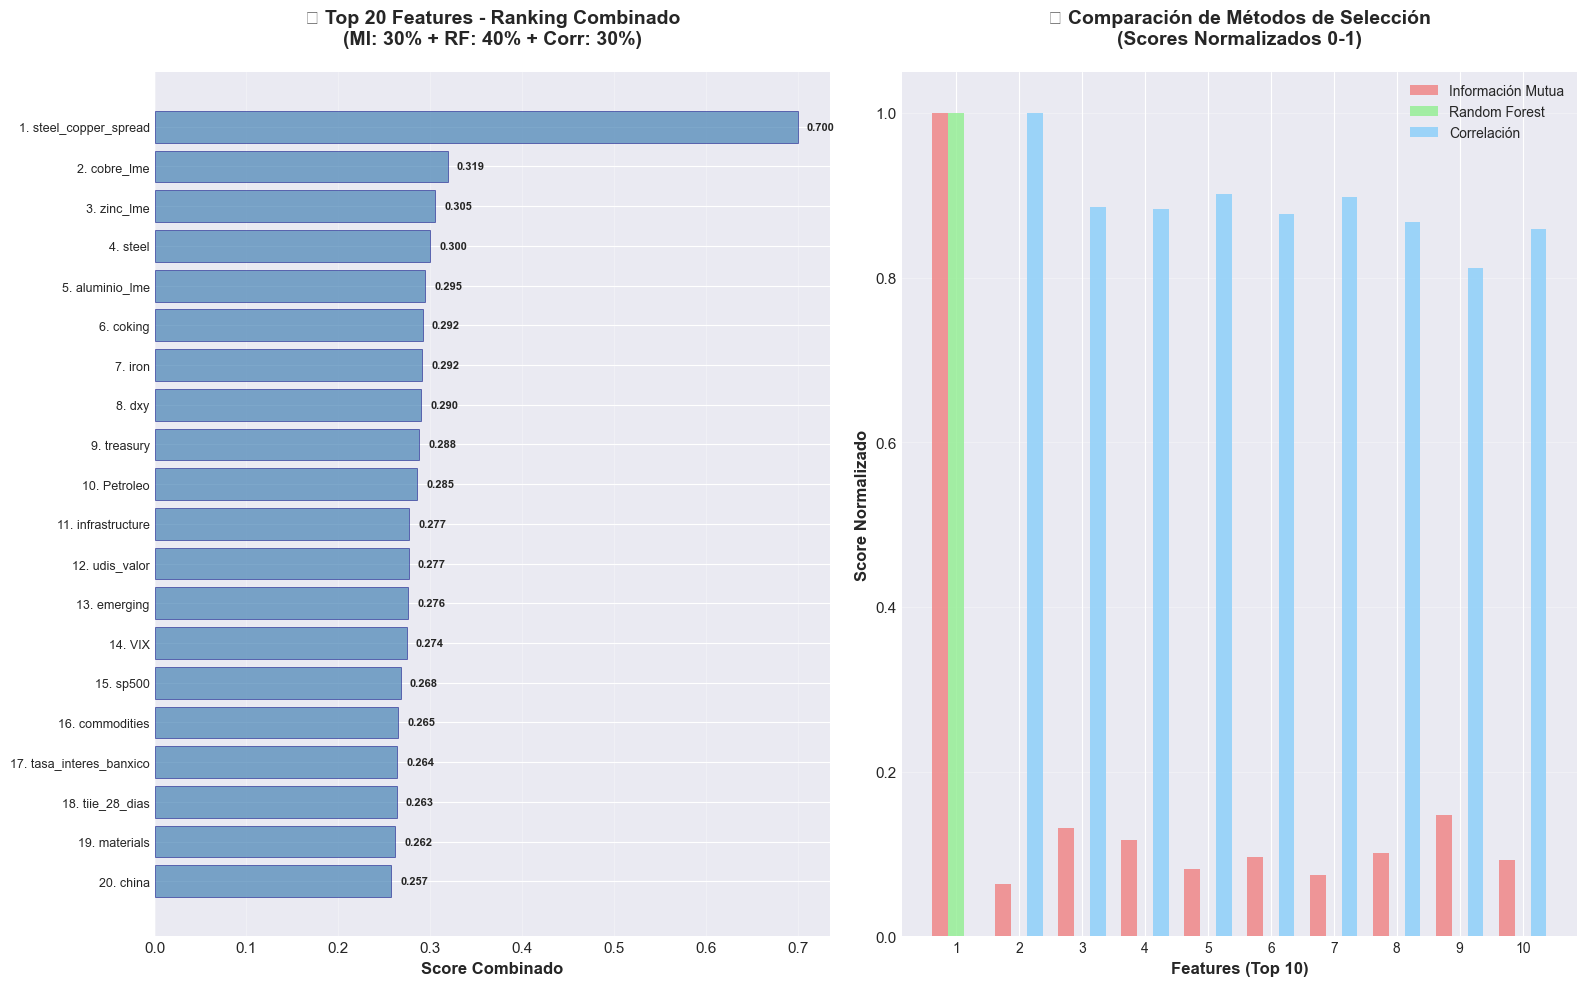


📋 TABLA RESUMEN - TOP 20 FEATURES
             Feature  Score Combinado  Info Mutua  Random Forest  Correlación
 steel_copper_spread           0.7000      1.0000            1.0       0.0000
           cobre_lme           0.3191      0.0636            0.0       1.0000
            zinc_lme           0.3052      0.1322            0.0       0.8850
               steel           0.3002      0.1172            0.0       0.8836
        aluminio_lme           0.2948      0.0814            0.0       0.9012
              coking           0.2919      0.0962            0.0       0.8768
                iron           0.2916      0.0743            0.0       0.8976
                 dxy           0.2903      0.1009            0.0       0.8668
            treasury           0.2877      0.1471            0.0       0.8120
            Petroleo           0.2854      0.0931            0.0       0.8583
      infrastructure           0.2774      0.1354            0.0       0.7892
          udis_valor         

In [68]:
# ========================================
# 12. SELECCIÓN DE FEATURES Y ANÁLISIS DE IMPORTANCIA
# ========================================

print("🎯 SELECCIÓN DE FEATURES Y ANÁLISIS DE IMPORTANCIA\n")
print("="*60)

# Preparar datos para análisis
# Combinar features engineered con variables originales
analysis_df = pd.concat([daily_data, features_df], axis=1)

# Eliminar la variable objetivo del conjunto de features
feature_cols = [col for col in analysis_df.columns if col != TARGET_VAR]
X = analysis_df[feature_cols]
y = analysis_df[TARGET_VAR]

# Eliminar filas con valores faltantes
valid_idx = X.notna().all(axis=1) & y.notna()
X_clean = X[valid_idx]
y_clean = y[valid_idx]

print(f"Datos para análisis: {X_clean.shape[0]} observaciones, {X_clean.shape[1]} features\n")

# 1. INFORMACIÓN MUTUA
print("1. Calculando Información Mutua...")
mi_scores = mutual_info_regression(X_clean, y_clean, random_state=42)
mi_df = pd.DataFrame({
    'feature': X_clean.columns,
    'mi_score': mi_scores
}).sort_values('mi_score', ascending=False)

print("\nTop 10 Features por Información Mutua:")
for idx, row in mi_df.head(10).iterrows():
    print(f"   {row['feature']:30s}: {row['mi_score']:.4f}")

# 2. RANDOM FOREST FEATURE IMPORTANCE
print("\n2. Calculando importancia con Random Forest...")
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_clean, y_clean)

rf_importance = pd.DataFrame({
    'feature': X_clean.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Features por Random Forest:")
for idx, row in rf_importance.head(10).iterrows():
    print(f"   {row['feature']:30s}: {row['importance']:.4f}")

# 3. CORRELACIÓN CON TARGET
print("\n3. Correlación con variable objetivo...")
correlations = X_clean.corrwith(y_clean).abs().sort_values(ascending=False)

print("\nTop 10 Features por Correlación:")
for feature, corr in correlations.head(10).items():
    print(f"   {feature:30s}: {corr:.4f}")

# 4. ANÁLISIS COMBINADO
print("\n" + "="*60)
print("📊 RANKING COMBINADO DE FEATURES")
print("="*60)

# Normalizar scores
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

combined_scores = pd.DataFrame({
    'feature': X_clean.columns,
    'mi_score': scaler.fit_transform(mi_scores.reshape(-1, 1)).flatten(),
    'rf_importance': scaler.fit_transform(rf_model.feature_importances_.reshape(-1, 1)).flatten(),
    'correlation': scaler.fit_transform(correlations.values.reshape(-1, 1)).flatten()
})

# Score combinado (promedio ponderado)
combined_scores['combined_score'] = (
    combined_scores['mi_score'] * 0.3 +
    combined_scores['rf_importance'] * 0.4 +
    combined_scores['correlation'] * 0.3
)

combined_scores = combined_scores.sort_values('combined_score', ascending=False)

print("\n🏆 TOP 20 FEATURES FINALES:")
print("-"*60)
selected_features = []
for idx, row in combined_scores.head(20).iterrows():
    selected_features.append(row['feature'])
    print(f"{len(selected_features):2d}. {row['feature']:30s}: {row['combined_score']:.4f}")

print(f"\n✅ Features seleccionadas guardadas: {len(selected_features)} variables")

# 5. VISUALIZACIÓN DEL TOP 20 FEATURES
print("\n5. Generando visualización del Top 20 Features...")

# Preparar datos para visualización
top_20 = combined_scores.head(20).copy()

# Crear figura con subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))

# Panel 1: Ranking combinado
bars1 = ax1.barh(range(len(top_20)), top_20['combined_score'], 
                 color='steelblue', alpha=0.7, edgecolor='navy', linewidth=0.5)
ax1.set_yticks(range(len(top_20)))
ax1.set_yticklabels([f"{i+1}. {feat}" for i, feat in enumerate(top_20['feature'])], 
                    fontsize=9)
ax1.set_xlabel('Score Combinado', fontsize=12, fontweight='bold')
ax1.set_title('🏆 Top 20 Features - Ranking Combinado\n(MI: 30% + RF: 40% + Corr: 30%)', 
              fontsize=14, fontweight='bold', pad=20)
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()

# Añadir valores en las barras
for i, (bar, score) in enumerate(zip(bars1, top_20['combined_score'])):
    ax1.text(score + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{score:.3f}', va='center', fontsize=8, fontweight='bold')

# Panel 2: Comparación de métodos
methods_data = top_20[['mi_score', 'rf_importance', 'correlation']].head(10)
x_pos = np.arange(len(methods_data))
width = 0.25

bars2_mi = ax2.bar(x_pos - width, methods_data['mi_score'], width, 
                   label='Información Mutua', color='lightcoral', alpha=0.8)
bars2_rf = ax2.bar(x_pos, methods_data['rf_importance'], width, 
                   label='Random Forest', color='lightgreen', alpha=0.8)
bars2_corr = ax2.bar(x_pos + width, methods_data['correlation'], width, 
                     label='Correlación', color='lightskyblue', alpha=0.8)

ax2.set_xlabel('Features (Top 10)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Score Normalizado', fontsize=12, fontweight='bold')
ax2.set_title('📊 Comparación de Métodos de Selección\n(Scores Normalizados 0-1)', 
              fontsize=14, fontweight='bold', pad=20)
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f"{i+1}" for i in range(len(methods_data))], fontsize=10)
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(axis='y', alpha=0.3)

# Ajustar layout
plt.tight_layout()

# Guardar imagen
output_path = '../docs/02_FEATURE_ANALYSIS/top_20_features.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"📊 Imagen guardada en: {output_path}")

plt.show()

# 6. TABLA RESUMEN PARA DOCUMENTACIÓN
print("\n" + "="*80)
print("📋 TABLA RESUMEN - TOP 20 FEATURES")
print("="*80)

summary_table = top_20[['feature', 'combined_score', 'mi_score', 'rf_importance', 'correlation']].copy()
summary_table.columns = ['Feature', 'Score Combinado', 'Info Mutua', 'Random Forest', 'Correlación']

# Formatear para mejor presentación
for col in ['Score Combinado', 'Info Mutua', 'Random Forest', 'Correlación']:
    summary_table[col] = summary_table[col].round(4)

print(summary_table.to_string(index=False))
print("\n✅ Análisis de importancia de features completado")

In [69]:
# ========================================
# 13. ANÁLISIS DE CORRELACIÓN DINÁMICA
# ========================================

print("📈 ANÁLISIS DE CORRELACIÓN DINÁMICA\n")
print("="*60)

# Seleccionar variables clave para análisis dinámico
dynamic_vars = [TARGET_VAR]
for var in ['iron', 'coking', 'gas_natural', 'commodities', 'tasa_interes_banxico', 'sp500', 'steel','VIX','aluminio_lme']:
    if var in daily_data.columns:
        dynamic_vars.append(var)

# Calcular correlaciones rolling
window = 60  # 60 días hábiles
rolling_corr = pd.DataFrame(index=daily_data.index)

for var in dynamic_vars[1:]:
    rolling_corr[f'corr_{var}'] = daily_data[TARGET_VAR].rolling(window=window).corr(daily_data[var])

# Visualización
fig = go.Figure()

for col in rolling_corr.columns:
    var_name = col.replace('corr_', '')
    fig.add_trace(go.Scatter(
        x=rolling_corr.index,
        y=rolling_corr[col],
        mode='lines',
        name=var_name,
        line=dict(width=2)
    ))

fig.add_hline(y=0, line_dash="dash", line_color="gray", opacity=0.5)
fig.add_hline(y=0.5, line_dash="dash", line_color="green", opacity=0.3)
fig.add_hline(y=-0.5, line_dash="dash", line_color="red", opacity=0.3)

fig.update_layout(
    title=f'Correlación Dinámica con {TARGET_VAR} (ventana={window} días)',
    xaxis_title='Fecha',
    yaxis_title='Correlación',
    height=500,
    hovermode='x unified',
    showlegend=True,
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01)
)

fig.show()

# Análisis de estabilidad de correlaciones
print("\n📊 Estabilidad de Correlaciones:")
print("="*50)

for col in rolling_corr.columns:
    var_name = col.replace('corr_', '')
    corr_series = rolling_corr[col].dropna()
    
    if len(corr_series) > 0:
        mean_corr = corr_series.mean()
        std_corr = corr_series.std()
        min_corr = corr_series.min()
        max_corr = corr_series.max()
        
        print(f"\n{var_name}:")
        print(f"   Media: {mean_corr:+.3f}")
        print(f"   Std Dev: {std_corr:.3f}")
        print(f"   Rango: [{min_corr:+.3f}, {max_corr:+.3f}]")
        
        if std_corr < 0.15:
            print("   ✅ Correlación ESTABLE")
        elif std_corr < 0.25:
            print("   ⚠️ Correlación MODERADAMENTE ESTABLE")
        else:
            print("   ❌ Correlación INESTABLE")

📈 ANÁLISIS DE CORRELACIÓN DINÁMICA




📊 Estabilidad de Correlaciones:

iron:
   Media: -0.017
   Std Dev: 0.132
   Rango: [-0.407, +0.402]
   ✅ Correlación ESTABLE

coking:
   Media: -0.015
   Std Dev: 0.146
   Rango: [-0.416, +0.333]
   ✅ Correlación ESTABLE

gas_natural:
   Media: +0.013
   Std Dev: 0.157
   Rango: [-0.418, +0.424]
   ⚠️ Correlación MODERADAMENTE ESTABLE

commodities:
   Media: +0.001
   Std Dev: 0.141
   Rango: [-0.393, +0.362]
   ✅ Correlación ESTABLE

tasa_interes_banxico:
   Media: +0.000
   Std Dev: 0.156
   Rango: [-0.469, +0.374]
   ⚠️ Correlación MODERADAMENTE ESTABLE

sp500:
   Media: +0.008
   Std Dev: 0.153
   Rango: [-0.473, +0.432]
   ⚠️ Correlación MODERADAMENTE ESTABLE

steel:
   Media: -0.016
   Std Dev: 0.123
   Rango: [-0.490, +0.327]
   ✅ Correlación ESTABLE

VIX:
   Media: +0.027
   Std Dev: 0.142
   Rango: [-0.397, +0.453]
   ✅ Correlación ESTABLE

aluminio_lme:
   Media: -0.012
   Std Dev: 0.135
   Rango: [-0.358, +0.437]
   ✅ Correlación ESTABLE


In [71]:
# ========================================
# 15. RESUMEN EJECUTIVO Y RECOMENDACIONES
# ========================================

print("📋 RESUMEN EJECUTIVO DEL ANÁLISIS\n")
print("="*80)

print("""
🎯 VARIABLE OBJETIVO: Precio de Varilla Corrugada (Steel Rebar LME)
""")

print("\n1️⃣ CARACTERÍSTICAS DE LA SERIE:")
print("-"*40)
print(f"   • Tendencia: {'ALCISTA' if trend_slope > 0 else 'BAJISTA'} ({trend_slope*252:.2f} unidades/año)")
print(f"   • Volatilidad anualizada promedio: {(returns.std() * np.sqrt(252)):.2%}")
print(f"   • Coeficiente de variación: {(target_series.std() / target_series.mean()):.2%}")
print(f"   • Distribución: {'NO NORMAL' if jb_pvalue < 0.05 else 'NORMAL'} (Jarque-Bera p={jb_pvalue:.4f})")

print("\n2️⃣ PROPIEDADES ESTADÍSTICAS:")
print("-"*40)
if not stationarity_original['ADF']['is_stationary']:
    print("   • Serie original: NO ESTACIONARIA")
    print("   • Transformación requerida: Primera diferencia o retornos logarítmicos")
else:
    print("   • Serie original: ESTACIONARIA")

print(f"   • Memoria: {'LARGA' if hurst_original > 0.5 else 'CORTA'} (H={hurst_original:.3f})")

if arch_test[1] < 0.05:
    print("   • Volatilidad: CONDICIONAL (efectos ARCH/GARCH presentes)")
else:
    print("   • Volatilidad: CONSTANTE")

print("\n3️⃣ RELACIONES CAUSALES IDENTIFICADAS:")
print("-"*40)
if causers:
    print("   Variables con causalidad de Granger significativa:")
    for var, pval in causers[:3]:
        print(f"   • {var}: p-value = {pval:.4f}")
else:
    print("   • No se identificaron relaciones causales significativas")

print("\n4️⃣ TOP 5 FEATURES MÁS IMPORTANTES:")
print("-"*40)
for i, feature in enumerate(selected_features[:5], 1):
    print(f"   {i}. {feature}")

print("\n5️⃣ RECOMENDACIONES PARA MODELADO:")
print("-"*40)

recommendations = []

# Basado en estacionariedad
if not stationarity_original['ADF']['is_stationary']:
    recommendations.append("• Aplicar diferenciación antes de modelar")

# Basado en memoria
if hurst_original > 0.6:
    recommendations.append("• Considerar modelos ARFIMA para capturar memoria larga")

# Basado en volatilidad
if arch_test[1] < 0.05:
    recommendations.append("• Implementar modelo GARCH para volatilidad condicional")

# Basado en cointegración
if 'johansen_test' in locals() and johansen_test.lr1[0] > johansen_test.cvt[0, 1]:
    recommendations.append("• Usar modelo VECM para capturar relaciones de largo plazo")

# Modelo MIDAS
recommendations.append("• MIDAS es altamente recomendado para integrar frecuencias mixtas")
recommendations.append("• Implementar validación walk-forward para series temporales")
recommendations.append("• Considerar ensemble de modelos (MIDAS + LSTM + XGBoost)")

for rec in recommendations:
    print(rec)

print("\n6️⃣ ARQUITECTURA PROPUESTA:")
print("-"*40)
print("""
   Nivel 1: Preprocesamiento
   ├── Detección y tratamiento de outliers
   ├── Diferenciación/transformación logarítmica
   └── Feature engineering temporal
   
   Nivel 2: Modelos Base
   ├── MIDAS (frecuencias mixtas)
   ├── LSTM (patrones no lineales)
   └── XGBoost (interacciones complejas)
   
   Nivel 3: Modelo de Volatilidad
   └── GARCH(1,1) para intervalos de confianza
   
   Nivel 4: Ensemble
   └── Stacking con meta-learner
""")

print("\n7️⃣ MÉTRICAS DE EVALUACIÓN SUGERIDAS:")
print("-"*40)
print("   • RMSE (Root Mean Square Error)")
print("   • MAPE (Mean Absolute Percentage Error)")
print("   • Directional Accuracy")
print("   • Sharpe Ratio (si se usa para trading)")
print("   • Coverage de intervalos de confianza")

print("\n" + "="*80)
print("✅ ANÁLISIS COMPLETO - DATOS LISTOS PARA MODELADO")
print("="*80)

# Guardar resultados clave
results_summary = {
    'target_variable': TARGET_VAR,
    'n_observations': len(target_series),
    'date_range': f"{target_series.index.min().date()} to {target_series.index.max().date()}",
    'trend_slope': trend_slope,
    'is_stationary': stationarity_original['ADF']['is_stationary'],
    'hurst_exponent': hurst_original,
    'arch_effects': arch_test[1] < 0.05,
    'selected_features': selected_features[:20],
    'recommendations': recommendations
}

print("\n💾 Resultados guardados en diccionario 'results_summary'")

📋 RESUMEN EJECUTIVO DEL ANÁLISIS


🎯 VARIABLE OBJETIVO: Precio de Varilla Corrugada (Steel Rebar LME)


1️⃣ CARACTERÍSTICAS DE LA SERIE:
----------------------------------------
   • Tendencia: ALCISTA (15.03 unidades/año)
   • Volatilidad anualizada promedio: 62.82%
   • Coeficiente de variación: 5.94%
   • Distribución: NO NORMAL (Jarque-Bera p=0.0000)

2️⃣ PROPIEDADES ESTADÍSTICAS:
----------------------------------------
   • Serie original: NO ESTACIONARIA
   • Transformación requerida: Primera diferencia o retornos logarítmicos
   • Memoria: CORTA (H=0.000)
   • Volatilidad: CONDICIONAL (efectos ARCH/GARCH presentes)

3️⃣ RELACIONES CAUSALES IDENTIFICADAS:
----------------------------------------
   Variables con causalidad de Granger significativa:
   • cobre_lme: p-value = 0.0000
   • aluminio_lme: p-value = 0.0000
   • iron: p-value = 0.0028

4️⃣ TOP 5 FEATURES MÁS IMPORTANTES:
----------------------------------------
   1. steel_copper_spread
   2. cobre_lme
   3. zinc_lme
  